# 2.03 Feature Extraction at Time Series Level for Clustering Nights
The following assumes that we have now selected a set of candidates where the night periods have been preprocessed to ensure that they are consistent and complete, with a consistent start and end time and candidates have been selected based broadly that they maximise the number of complete nights (determined by having zero missing intervals). Generating these features will provide the ability to look at the night periods as a whole, rather than individual intervals, and to cluster them based on their features. This is useful for clustering analysis, where we want to group similar nights together based on their features. The desire is to find patterns in the night periods that can be used to identify different types of nights, such as restful nights, restless nights, or nights with specific patterns of activity. This can help to identify different types of sleep disturbances or other activity that has an impact on the night period, and to provide insights into the underlying states of the patients during these periods.

In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
from datetime import time
import matplotlib.pyplot as plt
import seaborn as sns

from src.configurations import ThirtyMinute
from src.night_clustering import NightClustering
from src.sample_filter import SampleFilter
from src.time_series_analysis import plot_night_time_series
from src.config import FIGURES_DIR

2025-08-16 20:43:02.880 | INFO     | src.config:<module>:11 - PROJ_ROOT path is: C:\Users\ross\OneDrive\Documents\Masters\Project\masters_project


In [2]:
night_start = time(17, 0)
morning_end = time(11, 0)
sampling = ThirtyMinute()
min_nights = 30
missed_intervals = 1
max_break_run = 1
cob_nan_min = 0.2
iob_nan_min = 0.05
bg_nan_min = 0.2
sample = SampleFilter(
    night_start=night_start,
    morning_end=morning_end,
    sampling=sampling,
    missed_intervals=missed_intervals,
    max_break_run= max_break_run,
    min_nights=min_nights,
    cob_nan_min=cob_nan_min,
    iob_nan_min=iob_nan_min,
    bg_nan_min=bg_nan_min
)

df = sample.get_consolidated_df()
sample.return_counts()

2025-08-16 20:43:48.250 | INFO     | src.nights:_calculate_overall_stats:163 - No stats per night have been calculated for 67167655. Returning no output.
2025-08-16 20:43:55.526 | INFO     | src.sample_filter:__init__:68 - Number of nights objects created: 83
2025-08-16 20:44:01.803 | INFO     | src.sample_filter:return_counts:139 - For sample rate of 30 minutes:
  min_nights=30
  missed_intervals=1
2025-08-16 20:44:01.805 | INFO     | src.sample_filter:return_counts:142 - Number of candidates: 16
2025-08-16 20:44:01.805 | INFO     | src.sample_filter:return_counts:143 - Number of nights: 922


(16, 922)

In [3]:
df[['cob mean', 'cob min', 'cob max']] = df.groupby('id')[['cob mean', 'cob min', 'cob max']].transform(lambda x: x.interpolate(method='linear'))

Next, we need to select the columns that we want to extract features from. For the clustering of similar nights, we will use ['iob mean', 'cob mean', 'bg mean', 'cob max', 'iob max'] variables and extract additional features from these. The max variables are chosen because they may hold information about the peaks in the night periods, which may be indicative of specific patterns of activity or disturbances. The mean variables are chosen because they provide a summary of the overall activity during the night period, which can be used to identify different types of nights.

In [4]:
df_variables = df[['bg mean', 'bg min', 'bg max', 'iob mean', 'iob max', 'cob mean', 'cob max']].copy().astype(float)

## Experiment 1: Efficient Feature Extraction (Baseline)
The first experiment we will run is using the EfficientFCParameters() that will extract a set of features that are computationally efficient and suitable for clustering analysis. This will provide a good baseline for the feature extraction process and allow us to see how well the clustering works with a smaller set of custom features. Principal Component Analysis is applied in order to reduce the features for clustering to components that explain the maximum amount of variance, and thus have the most relevance. Initially, we set this to a threshold of 95% of the explained variance.

Feature Extraction: 100%|██████████| 6454/6454 [24:28<00:00,  4.39it/s]  


Extracted 5439 features for 922 nights.
Preprocessing night-level features (scaling and PCA)...
Dropped 2696 features.
PCA reduced dimensions from 2743 to 347.

Preprocessed PCA features for nights:
[[  6.53316821   0.56895019  -7.22082668 ...   0.09520905  -0.22947201
    0.60312091]
 [ 12.38076991  -3.28782741  13.49437402 ...  -0.15991753  -0.34531178
    0.43016153]
 [ 22.32111844 -17.23685443  -7.31961548 ...  -0.16011456  -0.40910095
   -0.57650841]
 [ 24.57700649  -7.42847416  11.59941146 ...  -0.56959949   0.64521399
   -0.46394734]
 [  4.77467721 -10.00702628  21.0523946  ...   0.03934913  -0.2878823
    0.52042621]]


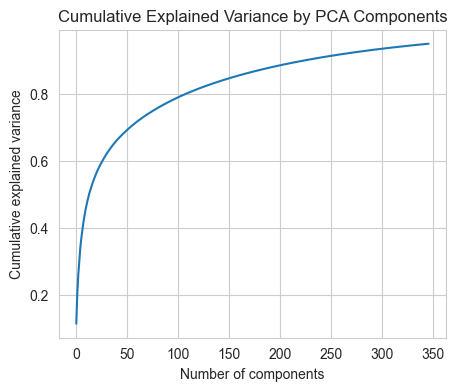

In [5]:
night_start_hour = 17  # Assuming night starts at 17:00
eff_analyser = NightClustering(df=df_variables, feature_settings='efficient', night_start_hour=night_start_hour)
night_features = eff_analyser.extract_night_level_features(multi_threaded=True)

# Preprocess Night-Level Features (Scale and PCA)
pca_features = eff_analyser.preprocess_night_features(n_components=0.95)
print("\nPreprocessed PCA features for nights:")
print(pca_features[:5])

# Plot the cumulative explained variance to help decide on the number of components
eff_analyser.plot_pca_cumulative_variance()

The number of features that are selected automatically do not help interpretability, which is important to understanding the patterns behind the clusters. Also, given the significant number of features this produces and the elbow curve doesn't have sufficient definition to determine the optimal number of components at a PCA n_components of 0.95 (95%).

As a baseline for comparison, we establish the silhouette scores for each n_cluster in a range of [2, 8]. The Silhouette Coefficient is a measure of how similar an object is to its own cluster compared to other clusters. A higher silhouette score indicates that the object is well matched to its own cluster and poorly matched to neighbouring clusters. The silhouette score ranges from -1 to 1, where a score close to 1 indicates that the object is well clustered, a score close to 0 indicates that the object is on or very close to the decision boundary between two neighbouring clusters, and a negative score indicates that the object may have been assigned to the wrong cluster.

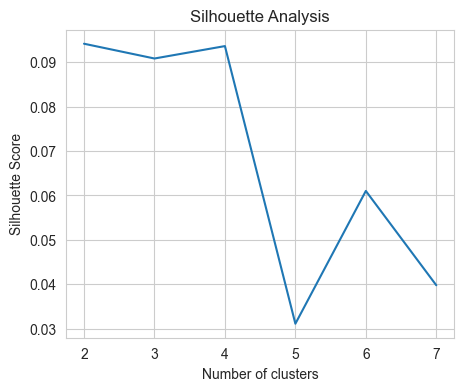

In [6]:
cluster_range = range(2,8)
baseline_silhoutte_scores = eff_analyser.silhouette_analysis(cluster_range)

## Experiment 2: Custom Feature Extraction
Given the significant number of features and components result from the PCA analysis, it makes better sense to limit the features extracted to those that have meaning in interpretation and relevance to the clustering. The following uses the custom features extracted from the data based on knowledge of the patterns we want to identify in the night periods. This will allow us to see how well the clustering works with a smaller set of custom features that are more interpretable and relevant to the patterns we want to identify.

Feature Extraction: 100%|██████████| 6454/6454 [00:06<00:00, 948.76it/s] 


Extracted 78 features for 922 nights.
Preprocessing night-level features (scaling and PCA)...
Dropped features from scaling: {'cob max__minimum', 'cob mean__minimum', 'iob max__count_above__t_100'}
PCA reduced dimensions from 75 to 23.


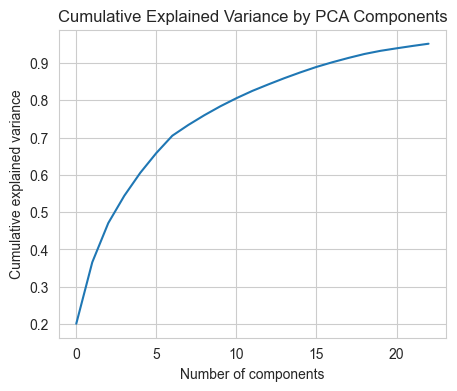

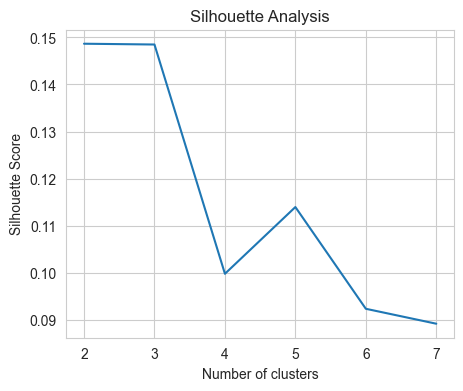

In [7]:
cust_analyser = NightClustering(df=df_variables, feature_settings='custom', night_start_hour=night_start_hour)
night_features = cust_analyser.extract_night_level_features()
pca_features = cust_analyser.preprocess_night_features(n_components=0.95)
cust_analyser.plot_pca_cumulative_variance()
custom_silhouette_scores = cust_analyser.silhouette_analysis(cluster_range)

Preprocessing night-level features (scaling and PCA)...
Dropped features from scaling: {'cob max__minimum', 'cob mean__minimum', 'iob max__count_above__t_100'}
PCA reduced dimensions from 75 to 10.


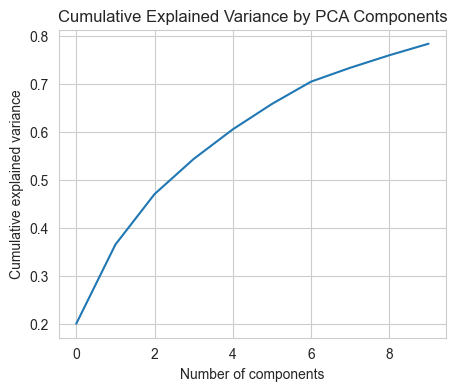

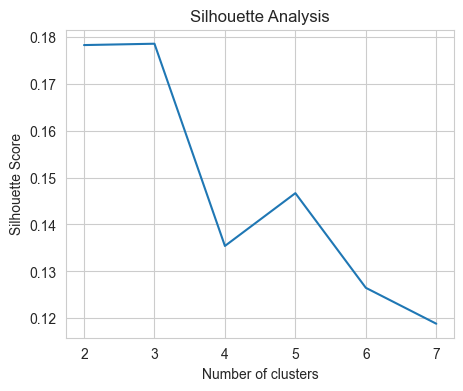

In [8]:
# Reducing to 10 components, which explains 80% of variance
pca_features = cust_analyser.preprocess_night_features(n_components=10)
cust_analyser.plot_pca_cumulative_variance()
custom_silhouette_scores = cust_analyser.silhouette_analysis(cluster_range)

This is poor range of silhoutte scores and the decreasing score as the number grows intimates that there is little distinction that can be drawn in the clustering analysis. It is not significantly different to the baseline and with notably less features. The custom features are not providing a significant improvement over the efficient features, but they are more interpretable and relevant to the patterns we want to identify. This is a good baseline for the feature extraction process and allows us to see how well the clustering works if we limit the number of components to 2, which is a more manageable number of features to work with and interpret, plus easily visualised in 2D.

Preprocessing night-level features (scaling and PCA)...
Dropped features from scaling: {'cob max__minimum', 'cob mean__minimum', 'iob max__count_above__t_100'}
PCA reduced dimensions from 75 to 2.
Explained variance: [0.20065463 0.16491781]


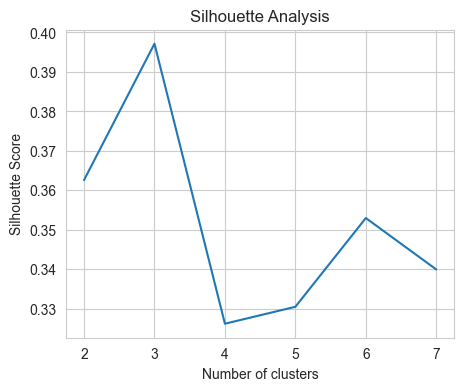

In [9]:
pca_features = cust_analyser.preprocess_night_features(n_components=2)
print(f'Explained variance: {cust_analyser.pca_model.explained_variance_ratio_}')
pca_silhouette_scores = cust_analyser.silhouette_analysis(cluster_range)

Now we have a better silhouette score for 3 clusters, which is a good indication that the clustering is working well. We can now look at the clusters and see how they differ from each other. Let visualise them first, which is easier to do with two components.

Night cluster distribution:
(array([0, 1, 2], dtype=int32), array([202, 483, 237]))


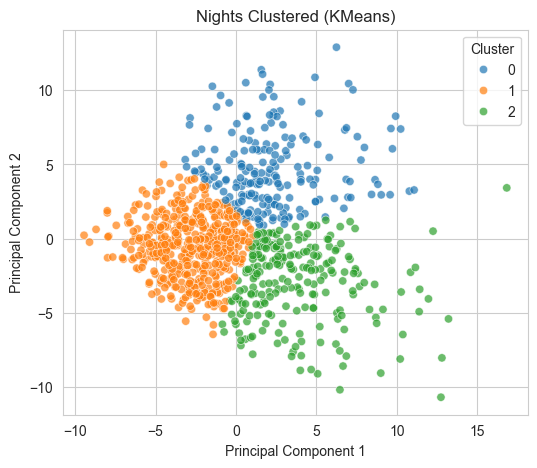

In [10]:
night_clusters = cust_analyser.cluster_nights(n_clusters=3)

The clusters are not perfectly separated and distinction between them isn't clear, as the silhoutte scores would suggest. It is not presently clear why the clustering is showing this pattern, to we need to analyse the clusters further to understand the patterns.

## Cluster Analysis: Centroid Analysis
Now we have established the clusters, we can look at the centroids of each cluster to see what the average feature values are for each cluster. This will help us understand the patterns in the night periods and how they differ between clusters.

In [11]:
# Get characteristics of clusters
cluster_centroids = cust_analyser.get_cluster_centroids()
print("\nCluster Centroids (mean feature values in original scale):")
cluster_centroids.T


Cluster Centroids (mean feature values in original scale):


cluster_label,0,1,2
bg max__maximum,207.693069,203.861284,294.443038
bg max__minimum,79.710396,78.394679,90.978903
bg max__median,127.257426,122.304348,159.738397
bg max__standard_deviation,34.056771,33.137766,58.253175
bg max__root_mean_square,138.424956,133.535318,181.985897
...,...,...,...
iob mean__first_location_of_minimum,0.582194,0.477479,0.567413
iob mean__last_location_of_minimum,0.610357,0.509994,0.599876
iob mean__sample_entropy,0.614304,1.108675,0.863390
iob mean__longest_strike_below_mean,17.915842,14.772257,16.210970


Cluster Centroids: Scaled Feature Means (Unscaled Means Overlay)


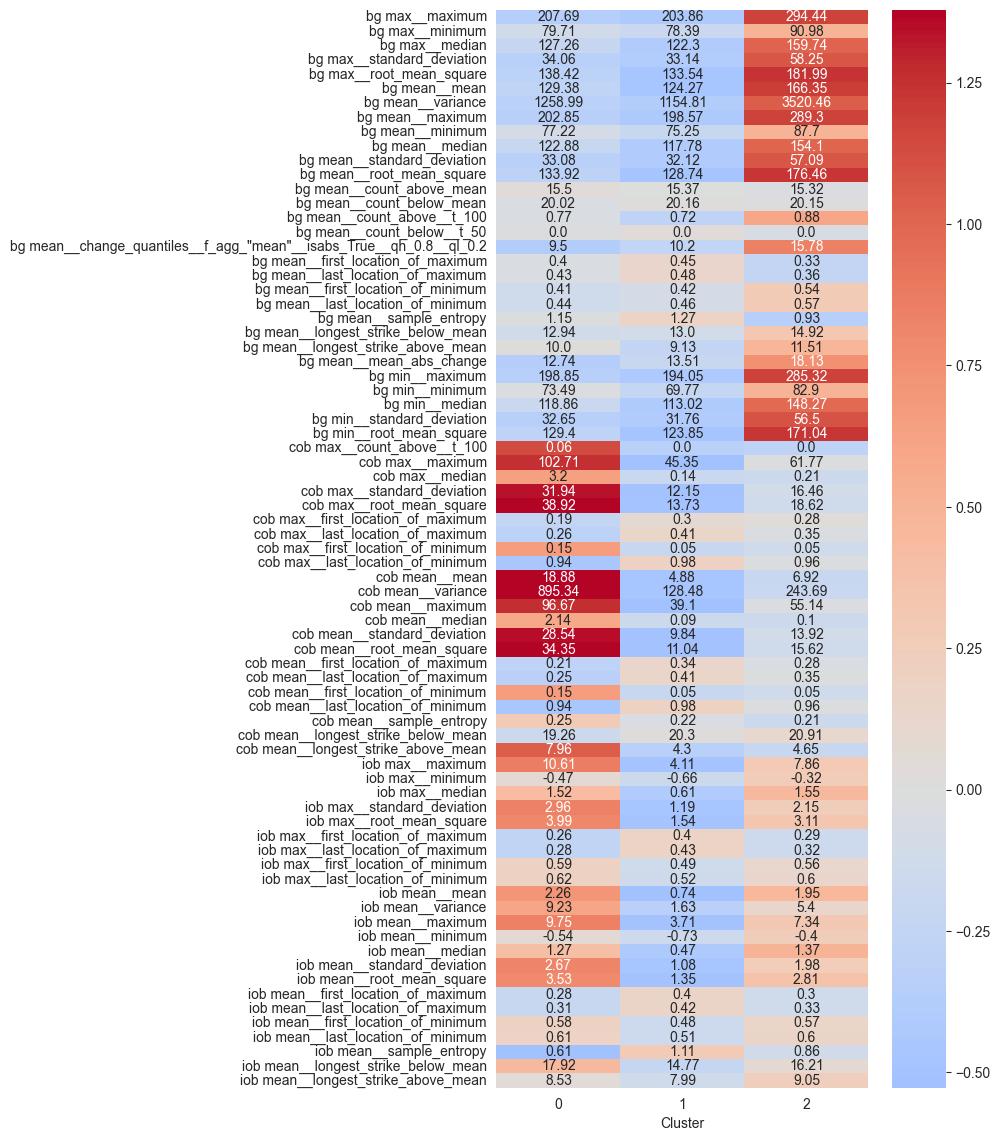

In [12]:
cust_analyser.heatmap_cluster_features()

The heatmap highlights the differences between the clusters, using still scaled values to allow comparison. The largest cluster (cluster 0 at n=510) has relatively low levels of BG and low levels of IOB and COB and low levels of variance in these. Cluster 1 (n=280) sees BG at low to 'standard' levels and higher levels of COB and variance, with higher maxima, but IOB relatively stable with, with low variance. Cluster 2 (n=132) has higher levels of BG, later maximums for BG and IOB variables and low variance as well. This suggests that cluster 2 is a cluster of nights with high levels of activity, cluster 0 is a cluster of nights with low levels of activity, and cluster 1 is a cluster of nights with more stable BG, high levels of COB but stable insulin. This is a good indication that the clustering is working well and that the features are providing useful information about the patterns in the night periods, but we don't yet know how to interpret these clusters in terms of the underlying states of the patients during these periods. We need to look at the individual nights in each cluster to see how they differ from each other and what patterns they exhibit. We'll fist look at the distribution of the clusters to see how they are distributed across the patients.

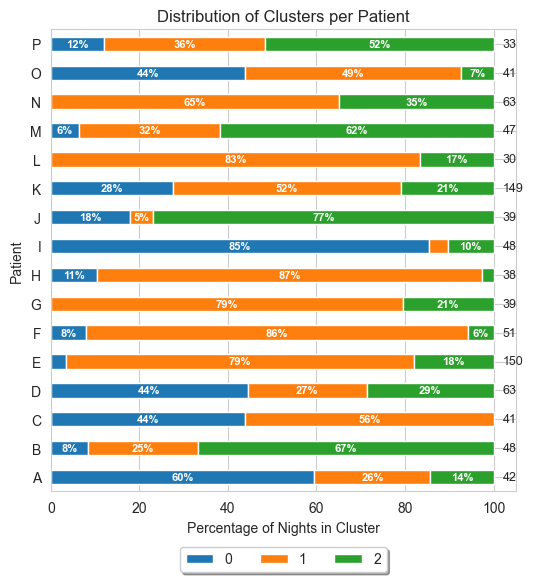

In [13]:
cust_analyser.plot_cluster_distribution()

The picture is mixed, but shows a clear bias of distributions to single clusters for some patients, which will be due to the clustering. We can measure put some metrics to these distributions using Entropy and Gini Coefficient, which will help us understand the diversity of clusters for each patient. The Entropy is a measure of the uncertainty or randomness in a distribution, while the Gini Coefficient is a measure of inequality in a distribution. A higher Entropy indicates a more diverse distribution, while a lower Gini Coefficient indicates a more equal distribution.

In [14]:
entropy = cust_analyser.calculate_distribution_metrics()

Mean entropy of cluster distribution per patient: 0.959
Normalised mean entropy of cluster distribution per patient: 0.605
Mean Gini coefficient of cluster distribution per patient: 0.402


The values show that the distribution of clusters is similar to how we have observed in the bar chart, with some patients having a more diverse distribution of clusters than others, resulting in Gini scores showing neither equality or inequality, and entropy scores showing a moderate level of diversity.

### Applying t-SNE for clustering

Plotting t-SNE with original clusters
t-SNE Visualisation of Night Features by KMeans Cluster


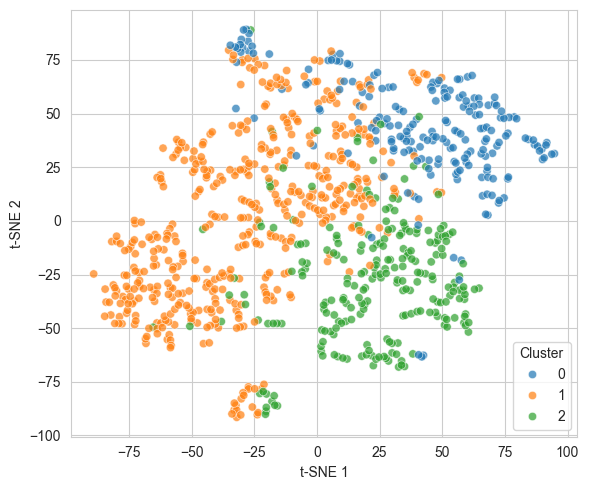

In [15]:
print('Plotting t-SNE with original clusters')
kwargs = {'perplexity': 10, 'max_iter': 80000}
cust_analyser.fit_tsne(**kwargs)
cust_analyser.plot_tsne(cluster_type='kmeans')

The t-SNE projection looks to have more separation and possibly not just 3 clusters. Lets experiment with 4 clusters in PCA and see how this plots to the t-SNE projection.

Night cluster distribution:
(array([0, 1, 2, 3], dtype=int32), array([303, 308, 185, 126]))


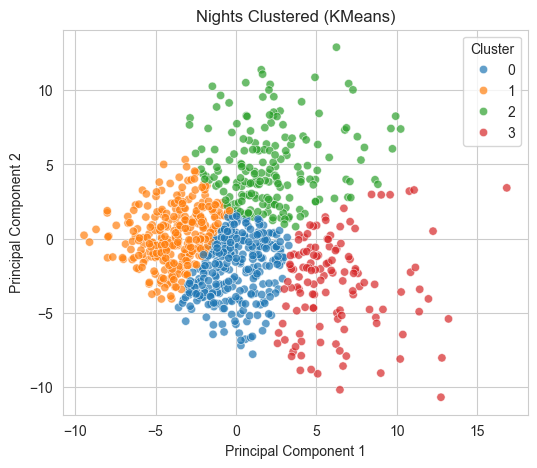

Plotting t-SNE with 4 clusters from PCA
t-SNE Visualisation of Night Features by KMeans Cluster


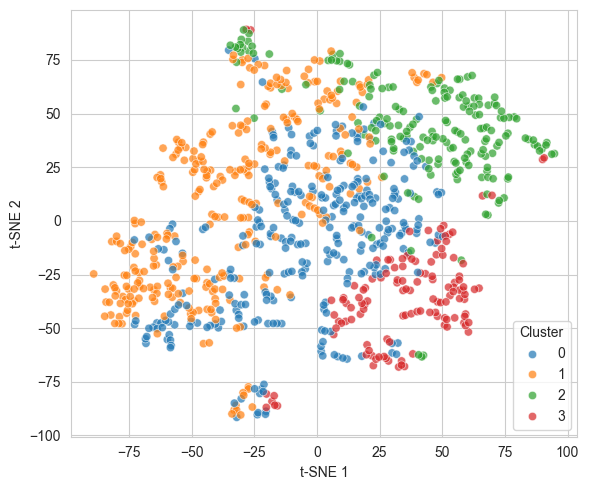

In [16]:
night_clusters = cust_analyser.cluster_nights(n_clusters=4)
print('Plotting t-SNE with 4 clusters from PCA')
kwargs = {'perplexity': 10, 'max_iter': 80000}
cust_analyser.fit_tsne(**kwargs)
cust_analyser.plot_tsne(cluster_type='kmeans')

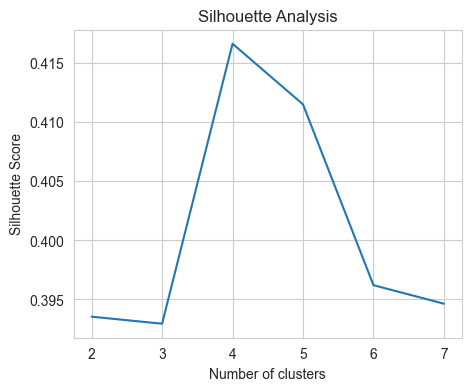

In [17]:
cluster_range = range(2, 8)
tsne_silhouette_scores = cust_analyser.silhouette_analysis(cluster_range=cluster_range, cluster_type='tsne', **kwargs)

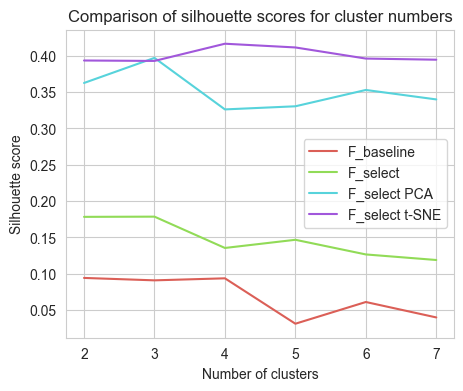

In [18]:
# Comparison of silhouette scores for the models
data = {'n_clusters': cluster_range,
        'F_baseline': baseline_silhoutte_scores,
        'F_select': custom_silhouette_scores,
        'F_select PCA': pca_silhouette_scores,
        'F_select t-SNE': tsne_silhouette_scores,}
silhouette_df = pd.DataFrame(data).melt(id_vars='n_clusters', var_name='clustering', value_name='score')

fig = plt.figure(figsize=(5, 4))
sns.lineplot(data=silhouette_df, x='n_clusters', y='score', hue='clustering', palette='hls')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette score')
plt.legend(title=None)
print('Comparison of silhouette scores for clusters ($K$)')
plt.savefig(FIGURES_DIR / 'silhouette_analysis.png')
plt.show()

From the plots above, it shows that there is generally better definition in the clusters from the t-SNE components. Looking at the heatmap also produced below

Max silhouette score:  0.42 for 4 clusters
t-SNE Visualisation of Night Features by KMeans Cluster


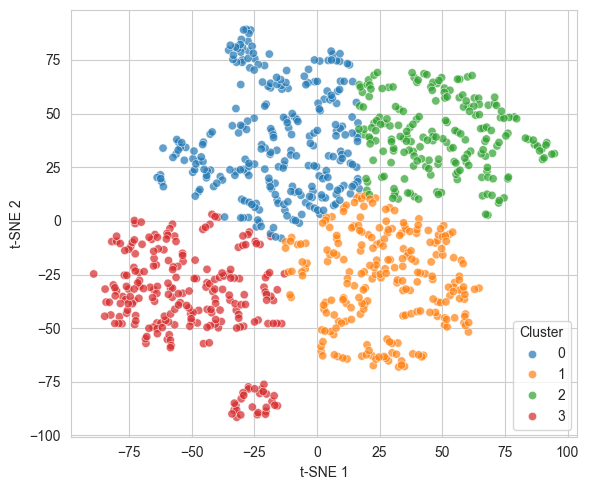

In [19]:
max_score = max(tsne_silhouette_scores)
idx = tsne_silhouette_scores.index(max_score)
n_clusters = list(cluster_range)[idx]
print(f'Max silhouette score: {max_score: .2f} for {n_clusters} clusters')
cust_analyser.clustering_tsne(n_clusters=n_clusters)
cust_analyser.plot_tsne(cluster_type='tsne')

Cluster Centroids: Scaled Feature Means (Unscaled Means Overlay)


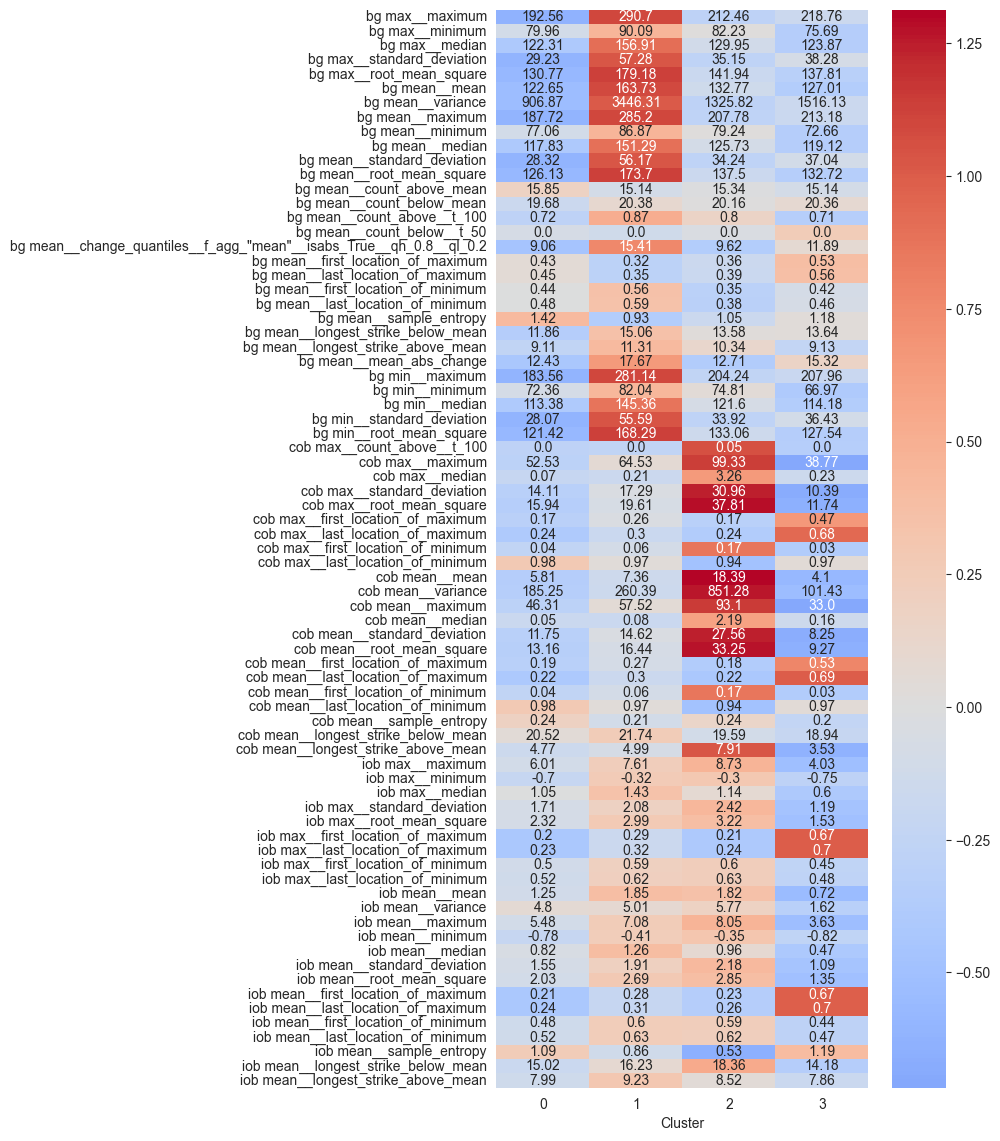

In [20]:
cust_analyser.heatmap_cluster_features(cluster_type='tsne')

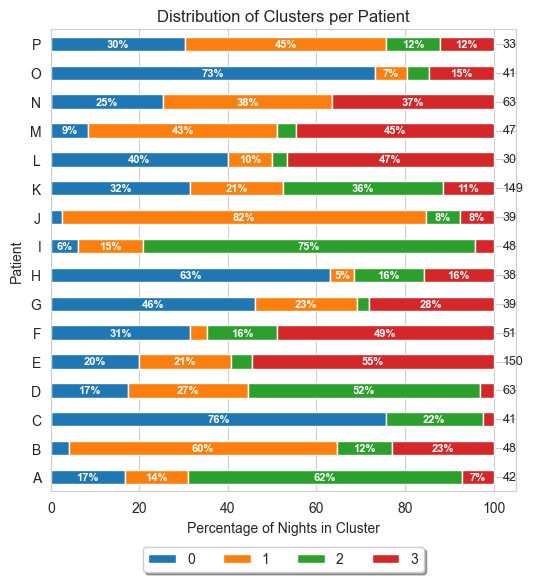

In [21]:
cust_analyser.plot_cluster_distribution(cluster_type='tsne')

In [22]:
entropy = cust_analyser.calculate_distribution_metrics(cluster_type='tsne')
night_counts = cust_analyser.get_summary_statistics()

Mean entropy of cluster distribution per patient: 1.221
Normalised mean entropy of cluster distribution per patient: 0.611
Mean Gini coefficient of cluster distribution per patient: 0.418


As could be anticipated, the entropy and Gini coefficient scores are improved, given the more clusters and distribution observed.

## Analysis of individuals - min/mid/max entropy
The following will now look at the three selected individuals and their night profiles to see if we can observe any differences between them. Individuals with min, mid and max entropy score are taken to see how their distributions look when plotted.

In [23]:
max_id = entropy.idxmax()
min_id = entropy.idxmin()
sorted_series = entropy.sort_values()
mid_id = sorted_series.index[len(sorted_series) // 2]

In [24]:
print('Night counts for each of the subjects:')
print(f'\tmin entropy: {entropy[min_id]:.2f}, nights: {night_counts.loc[min_id, "nights"]}')
print(f'\tmid entropy: {entropy[mid_id]:.2f}, nights: {night_counts.loc[mid_id, "nights"]}')
print(f'\tmax entropy: {entropy[max_id]:.2f}, nights: {night_counts.loc[max_id, "nights"]}')

Night counts for each of the subjects:
	min entropy: 0.45, nights: 39
	mid entropy: 0.59, nights: 39
	max entropy: 0.98, nights: 149


As a quick reminder of their distributions...

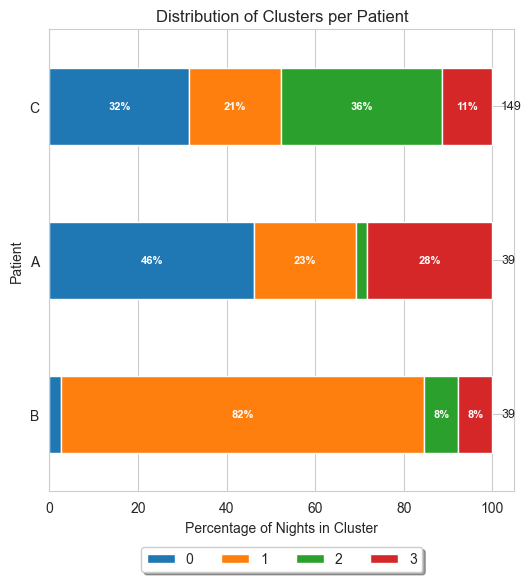

In [25]:
ids = [min_id, mid_id, max_id]
pivot_counts_tsne = cust_analyser.get_cluster_distributions(cluster_type='tsne')
cust_analyser.plot_cluster_distribution(pivot_counts_tsne.loc[ids])

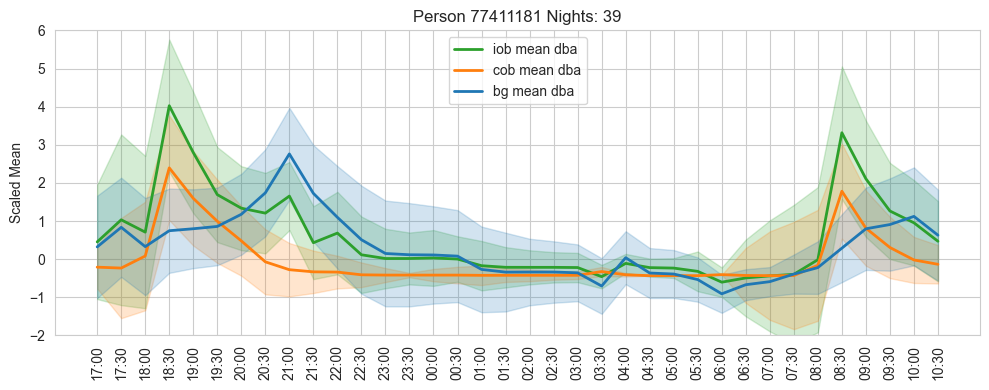

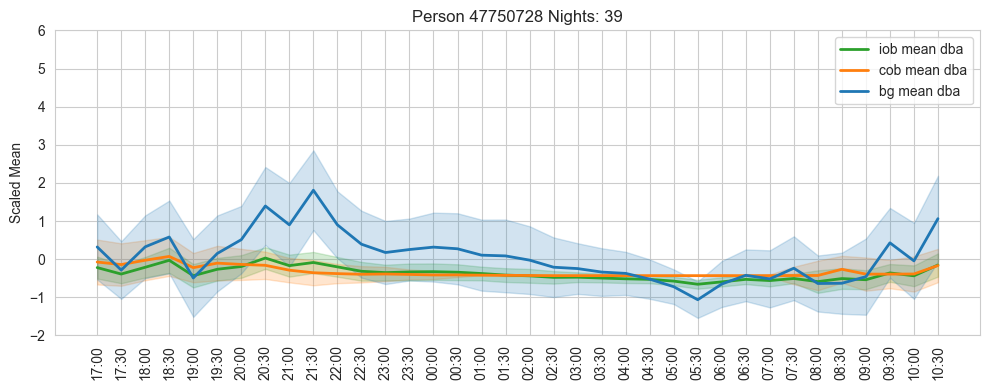

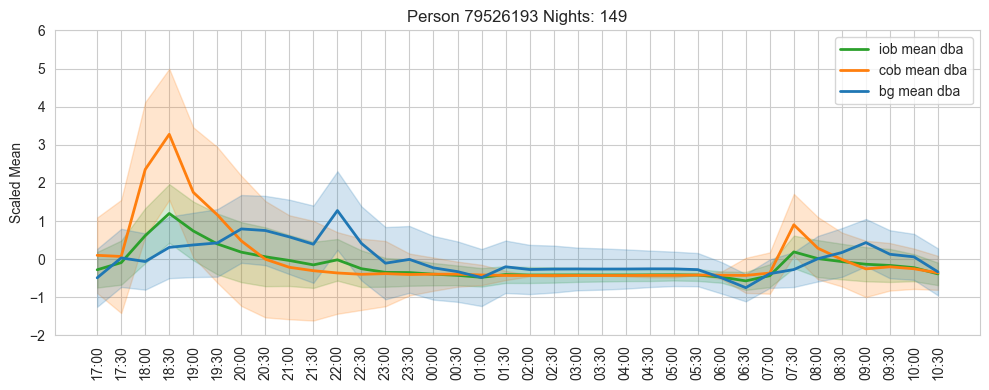

In [26]:
df = cust_analyser.return_dataset_with_clusters(scaled=True)

morning_end_hour = 11

for id_ in ids:
    plot_night_time_series(df.xs(key=id_, level='id', drop_level=False), zip_id=id_, night_start=night_start_hour, morning_end=morning_end.hour, method='dba', y_limits=(-2, 6))

There is nothing in these profiles that gives any more information as to the impact of the equality of distribution, though clearly notable differences exist. The next comparison that would be sensible is to select two groups and compare these statistically to see the differences between the two.

### Comparison of clusters
Another way we might compare these is to look comparisons of different clusters. The following will average profiles for the different clusters to observe how the different traits visible in the clusters look like in the profiles. We'll first compare the two clusters with the most and least significant variance in BG levels and see if there are patterns in the data.

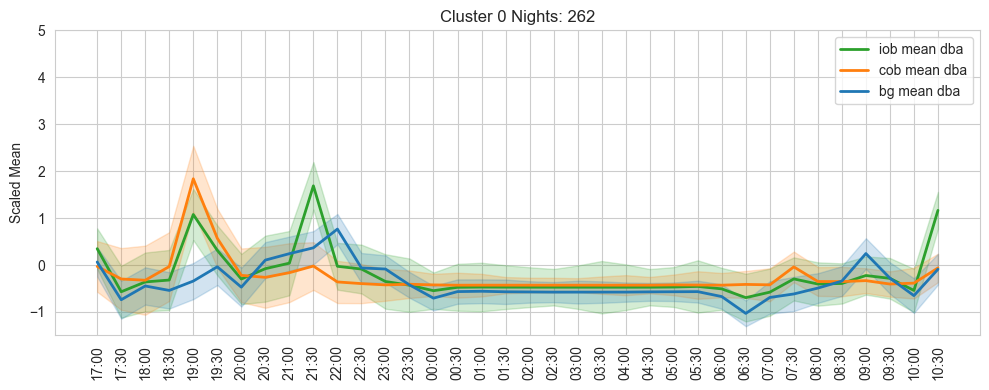

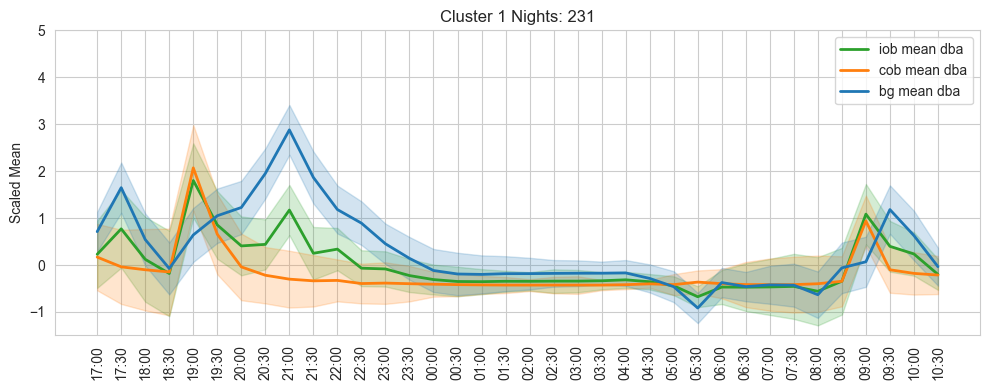

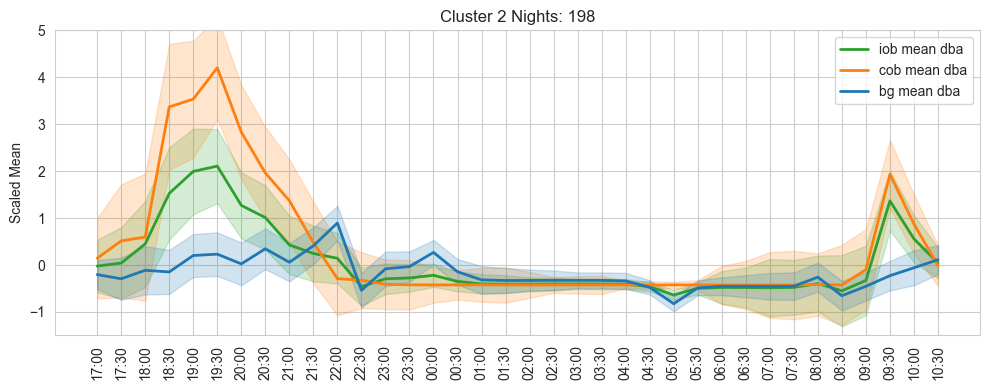

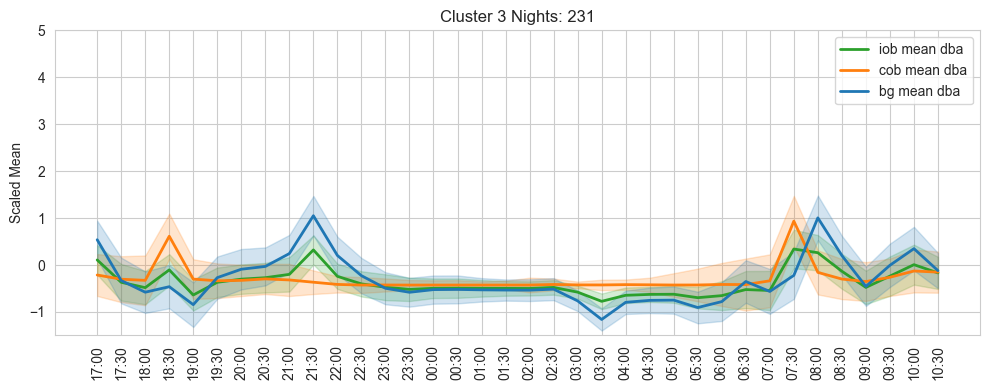

In [27]:
scaled_all_df = cust_analyser.return_dataset_with_clusters(scaled=True)
for cluster, df_cluster in scaled_all_df.groupby('tsne_cluster_label'):
    plot_night_time_series(df_cluster, night_start=night_start.hour, morning_end=morning_end.hour, method='dba', rolling_window=3, y_limits=(-1.5, 5), prescaled=True, cluster=cluster)

In [28]:
hist_data = (scaled_all_df.
             reset_index()[['id','night_start_date','tsne_cluster_label']].
             drop_duplicates().
             groupby(['id','tsne_cluster_label']).
             agg(nights=('night_start_date', 'size')
))
ylim = hist_data['nights'].max()

fig, axes = plt.subplots(figsize=(16, 3), ncols=4)
for c, df_hist in hist_data.groupby('tsne_cluster_label'):
    df_hist = df_hist.reset_index(drop=True).reset_index().sort_values('nights')
    sns.barplot(df_hist.sort_values('nights'), x='index',  y='nights', ax=axes[c])
    axes[c].set_xlabel('Patient')
    if c==0:
        axes[c].set_ylabel('Nights')
    axes[c].set_ylim(0, )


plt.show()

NameError: name 'alias' is not defined

These 4 cluster profiles are certainly showing different traits. Also, having looked at the counts of nights-per-individual to ensure they aren't dominated by a single person (and their behaviour), while cluster 3 is over-represented by one individual, there are is over half of the nights represented by others in a more even spread. The most notable of the observable characteristics are:

Cluster 0:
- Last meal intake is consistent at 19:00, BG rises from 17:30 to a consistent peak at 21:00 with insulin kept level until this peak, seeing then a gradual rate of decrease into the night.
- Meals aren't consistently taken in the morning period observed, or if so, not of significant carbohydrates.

Cluster 1:
- This group sees visibly the highest variance in BG, aligning to the features centroid averages, and highest peaks. Peaks are notable at 17:30 and the max peak at 21:00, following the last meal, which then sees a declining negative rate of change. This peak appears also without significant carb intake.
- They do start their morning with a meal which sees a matched response shortly following with their BG level.

Cluster 2:
-  General carb intake for this group is significantly different verse all sampled. COB has the largest peak (as the last meal) of all groups, taken over a possible hour period between 18:30-19:30. The breakfast peak is also the greatest, which both approximately double the amplitude of the next most significant cluster.
- BG does not see the a reciprocal increase but there is more disturbance later in the evening, morning.

Cluster 3:
- This cluster has the lowest calory intake of all. IOB also has a flat profile relative to the other clusters.
- BG sees a variance that is closest to cluster 2, relatively stable, but dipping below the mean but not significantly. The morning shows slightly more disturbance in BG.

Lets analyse some statistics behind them before we delve deeper. Putting focus on cluster 2 and 3 as being quite different in the profile of the variables, lets first start to look at how the profiles are different, from the perspective of their overnight glucose. We can shorten the observed period to between 22:00 and 06:00 which - although arbitrary - is more likely to represent a sleeping period for individuals. Using this, we can then look at the BG profiles and measure at each interval if the BG is statistically different.

In [138]:
hist_data

nights
id       tsne_cluster_label        
15558575 0                        7
         1                        6
         2                       26
         3                        3
21946407 0                        2
...                             ...
93606058 3                        6
97417885 0                       10
         1                       15
         2                        4
         3                        4

[62 rows x 1 columns]